In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score

df = pd.read_pickle("../data/all_data_with_features.pkl")
df = df.sort_values(["ID", "round"]).reset_index(drop=True)
df = df[df["Group"].isin(["Lc", "Hc"])]
df.head()

,ID,Group,round,Decmaps,Decpics,Expltime,Dectime_interval,Dectimes,Payoffs,prev_n_selected_times,prev_n_avg_payoff,Dectimes_interval
0,201901,Lc,1,"[262, 327, 310, 257, 145, 359, 303, 312, 206, ...","[269, 257, 310, 145]","[0, 14.32499999999709, 0, 0, 1.523000000001047...","[60.13799999999901, 20.718000000000757, 4.7610...","[56215.577, 56275.715, 56296.433, 56301.194, 5...","[2, 2, 4, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
1,201901,Lc,2,"[74, 248, 240, 36, 59, 217, 52, 132, 75, 2, 46...","[52, 46, 217, 59]","[0, 0, 0, 0, 0, 12.415000000000873, 0, 0, 17.6...","[13.49500000000262, 0.8909999999959837, 3.4740...","[56331.835, 56345.33, 56346.221, 56349.695, 56...","[4, 4, 6, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
2,201901,Lc,3,"[82, 60, 32, 131, 50, 241, 8, 87, 240, 140, 22...","[131, 140, 129, 119]","[75.79699999999139, 0, 8.709999999999127, 2.61...","[10.364999999997963, 1.2640000000028522, 3.502...","[56549.057, 56559.422, 56560.686, 56564.189, 5...","[2, 2, 2, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
3,201901,Lc,4,"[190, 178, 283, 325, 214, 314, 189, 216, 277, ...","[151, 168, 178, 153]","[0, 0, 0, 0, 15.001999999993131, 0, 0, 0, 0.85...","[73.02000000000407, 1.532999999995809, 1.97699...","[56572.971, 56645.991, 56647.524, 56649.501, 5...","[5, 5, 5, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
4,201901,Lc,5,"[183, 78, 328, 350, 63, 286, 39, 108, 356, 216...","[181, 192, 216, 183]","[0, 0, 0, 0, 13.172000000013213, 0, 0, 0, 0, 0...","[22.51299999999901, 1.5459999999948195, 1.9120...","[56859.999, 56882.512, 56884.058, 56885.97, 56...","[6, 6, 6, 6]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN


In [ ]:
sub_stats = (
    df[df["round"] <= 5]
    .groupby("ID")
    .apply(lambda g: g["Payoffs"].apply(sum).sum())
    .rename("early_total_reward")
)
df = df.merge(sub_stats, on="ID", how="left")
df.head()

,ID,Group,round,Decmaps,Decpics,Expltime,Dectime_interval,Dectimes,Payoffs,prev_n_selected_times,prev_n_avg_payoff,Dectimes_interval,early_total_reward
0,201901,Lc,1,"[262, 327, 310, 257, 145, 359, 303, 312, 206, ...","[269, 257, 310, 145]","[0, 14.32499999999709, 0, 0, 1.523000000001047...","[60.13799999999901, 20.718000000000757, 4.7610...","[56215.577, 56275.715, 56296.433, 56301.194, 5...","[2, 2, 4, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,83
1,201901,Lc,2,"[74, 248, 240, 36, 59, 217, 52, 132, 75, 2, 46...","[52, 46, 217, 59]","[0, 0, 0, 0, 0, 12.415000000000873, 0, 0, 17.6...","[13.49500000000262, 0.8909999999959837, 3.4740...","[56331.835, 56345.33, 56346.221, 56349.695, 56...","[4, 4, 6, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,83
2,201901,Lc,3,"[82, 60, 32, 131, 50, 241, 8, 87, 240, 140, 22...","[131, 140, 129, 119]","[75.79699999999139, 0, 8.709999999999127, 2.61...","[10.364999999997963, 1.2640000000028522, 3.502...","[56549.057, 56559.422, 56560.686, 56564.189, 5...","[2, 2, 2, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,83
3,201901,Lc,4,"[190, 178, 283, 325, 214, 314, 189, 216, 277, ...","[151, 168, 178, 153]","[0, 0, 0, 0, 15.001999999993131, 0, 0, 0, 0.85...","[73.02000000000407, 1.532999999995809, 1.97699...","[56572.971, 56645.991, 56647.524, 56649.501, 5...","[5, 5, 5, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,83
4,201901,Lc,5,"[183, 78, 328, 350, 63, 286, 39, 108, 356, 216...","[181, 192, 216, 183]","[0, 0, 0, 0, 13.172000000013213, 0, 0, 0, 0, 0...","[22.51299999999901, 1.5459999999948195, 1.9120...","[56859.999, 56882.512, 56884.058, 56885.97, 56...","[6, 6, 6, 6]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,83


In [ ]:
def make_per_image_dataset(df):
    rows = []

    for _, row in df.iterrows():
        ID = row["ID"]
        group = row["Group"]
        rnd = row["round"]

        decmaps = list(row["Decmaps"])
        expltimes = list(row["Expltime"])
        decpics = set(row["Decpics"])
        prev_times = list(row["prev_n_selected_times"])
        prev_avgpay = list(row["prev_n_avg_payoff"])
        early_reward = row["early_total_reward"]

        for img_id, cnt_before, avg_before in zip(decmaps, prev_times, prev_avgpay):
            label = 1 if img_id in decpics else 0

            rows.append(
                {
                    "ID": ID,
                    "Group": group,
                    "round": rnd,
                    "img_id": img_id,
                    "expltime": expltimes[decmaps.index(img_id)],
                    "cnt_before": cnt_before,
                    "avg_pay_before": avg_before,
                    "v_before": max(2, (cnt_before + 1) * avg_before),
                    "early_reward": early_reward,
                    "label": label,
                }
            )

    return pd.DataFrame(rows)


data_img = make_per_image_dataset(df)
print(data_img.head(20))

        ID Group  round  img_id  expltime  cnt_before  avg_pay_before  \
0   201901    Lc      1     262     0.000           0             0.0   
1   201901    Lc      1     327    14.325           0             0.0   
2   201901    Lc      1     310     0.000           0             0.0   
3   201901    Lc      1     257     0.000           0             0.0   
4   201901    Lc      1     145     1.523           0             0.0   
5   201901    Lc      1     359     0.000           0             0.0   
6   201901    Lc      1     303     0.000           0             0.0   
7   201901    Lc      1     312     2.697           0             0.0   
8   201901    Lc      1     206     0.000           0             0.0   
9   201901    Lc      1     353     0.000           0             0.0   
10  201901    Lc      1     190     0.000           0             0.0   
11  201901    Lc      1     169     0.000           0             0.0   
12  201901    Lc      1     301     0.000          

In [ ]:
def set_seed(seed):
    import random

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


features = [
    "round",
    "img_id",
    "expltime",
    "cnt_before",
    "avg_pay_before",
    "early_reward",
]


def get_loaders(data_img, feature_cols_num=features):
    y = data_img["label"].astype("float32")

    feature_cols_cat = ["Group", "ID"]

    X = data_img[feature_cols_num + feature_cols_cat]

    n_rounds = 20
    train_mask = (data_img["round"] <= n_rounds) & (data_img["round"] > 5)
    test_mask = data_img["round"] > n_rounds

    X_train_raw = X.loc[train_mask]
    X_test_raw = X.loc[test_mask]
    y_train = y.loc[train_mask].values.astype("float32")
    y_test = y.loc[test_mask].values.astype("float32")

    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), feature_cols_num),
            (
                "cat",
                OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                feature_cols_cat,
            ),
        ]
    )

    X_train = preprocess.fit_transform(X_train_raw)
    X_test = preprocess.transform(X_test_raw)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    batch_size = 256

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return X_train, y_train, train_loader, test_loader, test_mask, y_test


class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

In [ ]:
set_seed(42)

X_train, y_train, train_loader, test_loader, test_mask, y_test = get_loaders(data_img)

input_dim = X_train.shape[1]
model = MLP(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

pos = y_train.sum()
neg = len(y_train) - pos
pos_weight_value = neg / pos

pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)

            all_probs.append(probs.cpu())
            all_labels.append(yb)

    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    y_pred = (all_probs >= 0.5).astype(int)
    acc = accuracy_score(all_labels, y_pred)
    auc = roc_auc_score(all_labels, all_probs)

    test_df_epoch = data_img.loc[test_mask].copy().reset_index(drop=True)

    assert len(test_df_epoch) == len(
        all_probs
    ), f"len(test_df_epoch)={len(test_df_epoch)}, len(all_probs)={len(all_probs)} 不一致"

    test_df_epoch["prob"] = all_probs

    hits4_list = []
    full4_count = 0

    hits8_list = []
    full8_count = 0

    hits12_list = []
    full12_count = 0

    for (_, _), g in test_df_epoch.groupby(["ID", "round"]):
        g_sorted = g.sort_values("prob", ascending=False)

        # top4
        top4 = g_sorted.head(4)
        hits4 = top4["label"].sum()
        hits4_list.append(hits4)
        if hits4 == 4:
            full4_count += 1

        # top8
        top8 = g_sorted.head(8)
        hits8 = top8["label"].sum()
        hits8_list.append(hits8)
        if hits8 == 4:
            full8_count += 1

        # top12
        top12 = g_sorted.head(12)
        hits12 = top12["label"].sum()
        hits12_list.append(hits12)
        if hits12 == 4:
            full12_count += 1

    mean_hits4 = float(np.mean(hits4_list))
    full4_ratio = full4_count / len(hits4_list)

    mean_hits8 = float(np.mean(hits8_list))
    full8_ratio = full8_count / len(hits8_list)

    mean_hits12 = float(np.mean(hits12_list))
    full12_ratio = full12_count / len(hits12_list)

    print(
        f"Epoch {epoch:02d} | train loss {avg_loss:.4f} | "
        f"test acc {acc:.3f} | "
        f"test AUC {auc:.3f} | "
        f"top4 mean hits {mean_hits4:.2f} | "
        f"top4 all-correct {full4_ratio:.3f} | "
        f"top8 mean hits {mean_hits8:.2f} | "
        f"top8 all-covered {full8_ratio:.3f} | "
        f"top12 mean hits {mean_hits12:.2f} | "
        f"top12 all-covered {full12_ratio:.3f}"
    )


    for grp_name, df_g in test_df_epoch.groupby("Group"):
        y_g = df_g["label"].values
        prob_g = df_g["prob"].values

        if len(np.unique(y_g)) < 2:
            print(f"[{grp_name}] only one class in labels, skip AUC")
            auc_g = np.nan
        else:
            auc_g = roc_auc_score(y_g, prob_g)

        hits4_g, hits8_g, hits12_g = [], [], []
        full4_g = full8_g = full12_g = 0

        for (_, _), g_round in df_g.groupby(["ID", "round"]):
            g_sorted = g_round.sort_values("prob", ascending=False)

            # top4
            top4 = g_sorted.head(4)
            h4 = top4["label"].sum()
            hits4_g.append(h4)
            if h4 == 4:
                full4_g += 1

            # top8
            top8 = g_sorted.head(8)
            h8 = top8["label"].sum()
            hits8_g.append(h8)
            if h8 == 4:
                full8_g += 1

            # top12
            top12 = g_sorted.head(12)
            h12 = top12["label"].sum()
            hits12_g.append(h12)
            if h12 == 4:
                full12_g += 1

        mean_hits4_g = float(np.mean(hits4_g))
        mean_hits8_g = float(np.mean(hits8_g))
        mean_hits12_g = float(np.mean(hits12_g))

        full4_ratio_g = full4_g / len(hits4_g)
        full8_ratio_g = full8_g / len(hits8_g)
        full12_ratio_g = full12_g / len(hits12_g)

        print(
            f"  [{grp_name}] AUC {auc_g:.3f} | "
            f"top4 mean {mean_hits4_g:.2f}, all4 {full4_ratio_g:.3f} | "
            f"top8 mean {mean_hits8_g:.2f}, all4@8 {full8_ratio_g:.3f} | "
            f"top12 mean {mean_hits12_g:.2f}, all4@12 {full12_ratio_g:.3f}"
        )

Epoch 01 | train loss 1.1089 | test acc 0.673 | test AUC 0.635 | top4 mean hits 1.39 | top4 all-correct 0.008 | top8 mean hits 2.25 | top8 all-covered 0.149 | top12 mean hits 3.07 | top12 all-covered 0.521
  [Hc] AUC 0.672 | top4 mean 1.43, all4 0.000 | top8 mean 2.21, all4@8 0.162 | top12 mean 3.09, all4@12 0.515
  [Lc] AUC 0.634 | top4 mean 1.34, all4 0.019 | top8 mean 2.30, all4@8 0.132 | top12 mean 3.06, all4@12 0.528
Epoch 02 | train loss 1.0942 | test acc 0.738 | test AUC 0.644 | top4 mean hits 1.39 | top4 all-correct 0.017 | top8 mean hits 2.31 | top8 all-covered 0.165 | top12 mean hits 3.07 | top12 all-covered 0.521
  [Hc] AUC 0.677 | top4 mean 1.41, all4 0.015 | top8 mean 2.28, all4@8 0.162 | top12 mean 3.06, all4@12 0.515
  [Lc] AUC 0.627 | top4 mean 1.36, all4 0.019 | top8 mean 2.34, all4@8 0.170 | top12 mean 3.08, all4@12 0.528
Epoch 03 | train loss 1.0849 | test acc 0.757 | test AUC 0.656 | top4 mean hits 1.40 | top4 all-correct 0.017 | top8 mean hits 2.30 | top8 all-cover

In [ ]:
import numpy as np
import torch
from sklearn.metrics import roc_auc_score

model.eval()
all_probs = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits)  # [B]
        all_probs.append(probs.cpu())
        all_labels.append(yb)

all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()


test_df_epoch = data_img.loc[test_mask].copy().reset_index(drop=True)

assert len(test_df_epoch) == len(all_probs), \
    f"len(test_df_epoch)={len(test_df_epoch)}, len(all_probs)={len(all_probs)} 不一致"

test_df_epoch["prob"] = all_probs
test_df_epoch["label"] = test_df_epoch["label"].astype(int)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def compute_subject_hits(test_df_epoch):
    rows = []

    for (grp, sid), g_sub in test_df_epoch.groupby(["Group", "ID"]):
        y_sub = g_sub["label"].values
        prob_sub = g_sub["prob"].values
        if len(np.unique(y_sub)) < 2:
            auc_sub = np.nan
        else:
            auc_sub = roc_auc_score(y_sub, prob_sub)
        hits4_list, hits8_list = [], []

        for _, g_round in g_sub.groupby("round"):
            g_sorted = g_round.sort_values("prob", ascending=False)

            top4 = g_sorted.head(4)
            top8 = g_sorted.head(8)

            h4 = int(top4["label"].sum())
            h8 = int(top8["label"].sum())

            hits4_list.append(h4)
            hits8_list.append(h8)

        hits4_mean = float(np.mean(hits4_list))
        hits8_mean = float(np.mean(hits8_list))

        rows.append({
            "ID": sid,
            "Group": grp,
            "hits4": hits4_mean,
            "hits8": hits8_mean,
            "auc": auc_sub,
        })

    return pd.DataFrame(rows)

sub_df = compute_subject_hits(test_df_epoch)
print(sub_df.head())


       ID Group     hits4     hits8       auc
0  201902    Hc  1.250000  2.000000  0.558594
1  201908    Hc  2.250000  3.000000  0.743164
2  202505    Hc  2.454545  3.363636  0.880556
3  202507    Hc  1.214286  1.928571  0.591768
4  202509    Hc  1.363636  2.272727  0.645403


In [ ]:
sub_df

,ID,Group,hits4,hits8,auc
0,201902,Hc,1.250000,2.000000,0.558594
1,201908,Hc,2.250000,3.000000,0.743164
2,202505,Hc,2.454545,3.363636,0.880556
3,202507,Hc,1.214286,1.928571,0.591768
4,202509,Hc,1.363636,2.272727,0.645403
5,202511,Hc,2.375000,3.125000,0.797852
6,202513,Hc,1.375000,2.062500,0.636841
7,201901,Lc,1.750000,2.000000,0.615234
8,202502,Lc,1.000000,2.333333,0.600694
9,202504,Lc,1.750000,3.083333,0.767036


In [ ]:
from scipy.stats import ttest_ind

hc = sub_df[sub_df["Group"] == "Hc"]
lc = sub_df[sub_df["Group"] == "Lc"]

hc_hits4 = hc["hits4"].dropna()
lc_hits4 = lc["hits4"].dropna()

hc_hits8 = hc["hits8"].dropna()
lc_hits8 = lc["hits8"].dropna()

t4, p4 = ttest_ind(hc_hits4, lc_hits4, equal_var=False)
t8, p8 = ttest_ind(hc_hits8, lc_hits8, equal_var=False)

print(f"hits@4: Hc mean={hc_hits4.mean():.2f}, Lc mean={lc_hits4.mean():.2f}, t={t4:.3f}, p={p4:.4f}")
print(f"hits@8: Hc mean={hc_hits8.mean():.2f}, Lc mean={lc_hits8.mean():.2f}, t={t8:.3f}, p={p8:.4f}")


hits@4: Hc mean=1.75, Lc mean=1.29, t=1.392, p=0.1898
hits@8: Hc mean=2.54, Lc mean=2.05, t=1.105, p=0.2952


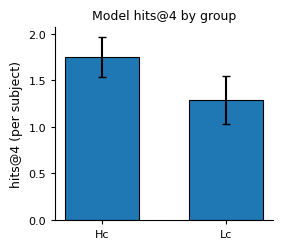

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mean_sem(x):
    return np.mean(x), np.std(x, ddof=1) / np.sqrt(len(x))

mean4_hc, sem4_hc = mean_sem(hc_hits4)
mean4_lc, sem4_lc = mean_sem(lc_hits4)

mean8_hc, sem8_hc = mean_sem(hc_hits8)
mean8_lc, sem8_lc = mean_sem(lc_hits8)

groups = ["Hc", "Lc"]
x = np.arange(len(groups))

fig, ax = plt.subplots(figsize=(3.0, 2.6))

means_4 = [mean4_hc, mean4_lc]
sems_4 = [sem4_hc, sem4_lc]

ax.bar(
    x,
    means_4,
    yerr=sems_4,
    capsize=3,
    width=0.6,
    linewidth=0.8,
    edgecolor="black",
)

ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=8)
ax.set_ylabel("hits@4 (per subject)", fontsize=9)
ax.set_title("Model hits@4 by group", fontsize=9)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(direction="out", length=3, width=0.8, labelsize=8)

fig.tight_layout()
plt.show()

fig.savefig('hits4_by_group.svg', format='svg', dpi=300, bbox_inches='tight')

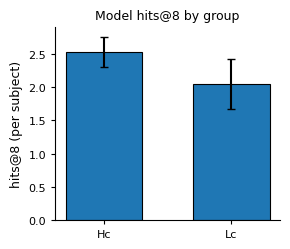

In [ ]:
fig, ax = plt.subplots(figsize=(3.0, 2.6))

means_8 = [mean8_hc, mean8_lc]
sems_8 = [sem8_hc, sem8_lc]

ax.bar(
    x,
    means_8,
    yerr=sems_8,
    capsize=3,
    width=0.6,
    linewidth=0.8,
    edgecolor="black",
)

ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=8)
ax.set_ylabel("hits@8 (per subject)", fontsize=9)
ax.set_title("Model hits@8 by group", fontsize=9)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction="out", length=3, width=0.8, labelsize=8)

fig.tight_layout()
plt.show()

fig.savefig('hits8_by_group.svg', format='svg', dpi=300, bbox_inches='tight')

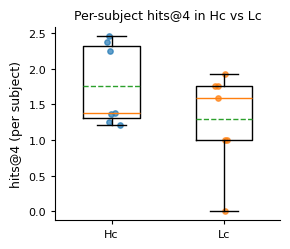

In [ ]:
hc_hits4 = hc_hits4.reset_index(drop=True)
lc_hits4 = lc_hits4.reset_index(drop=True)

data = [hc_hits4, lc_hits4]
labels = ["Hc", "Lc"]

fig, ax = plt.subplots(figsize=(3.0, 2.6))

bp = ax.boxplot(
    data,
    labels=labels,
    showmeans=True,
    meanline=True,
    widths=0.5,
)

for i, d in enumerate(data, start=1):
    x_jitter = np.random.normal(loc=i, scale=0.04, size=len(d))
    ax.scatter(x_jitter, d, alpha=0.7, s=15)

ax.set_ylabel("hits@4 (per subject)", fontsize=9)
ax.set_title("Per-subject hits@4 in Hc vs Lc", fontsize=9)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction="out", length=3, width=0.8, labelsize=8)

fig.tight_layout()
plt.show()

fig.savefig('hits4_boxplot_by_group.svg', format='svg', dpi=300, bbox_inches='tight')

(121, 20) (121, 20)


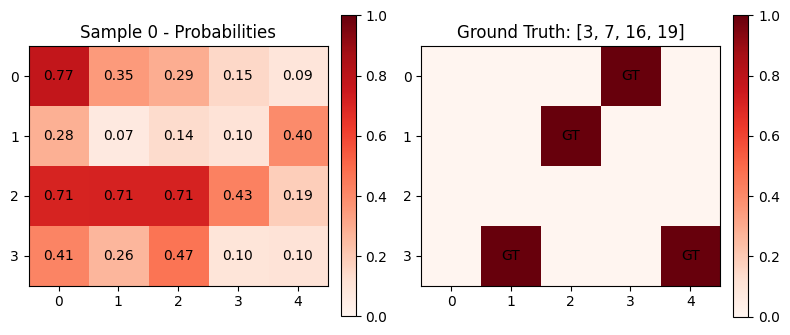

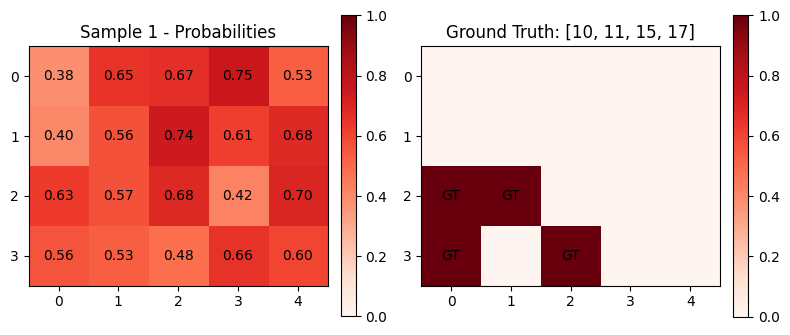

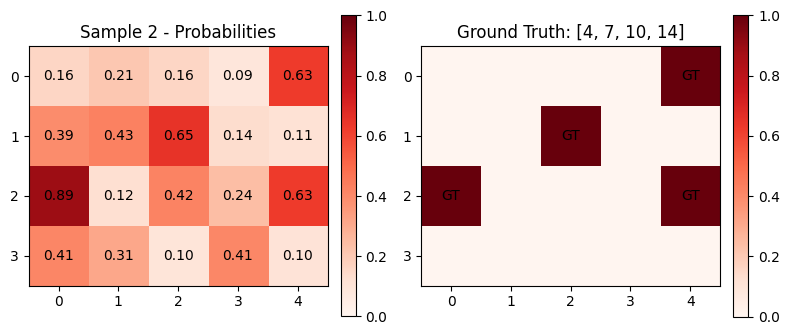

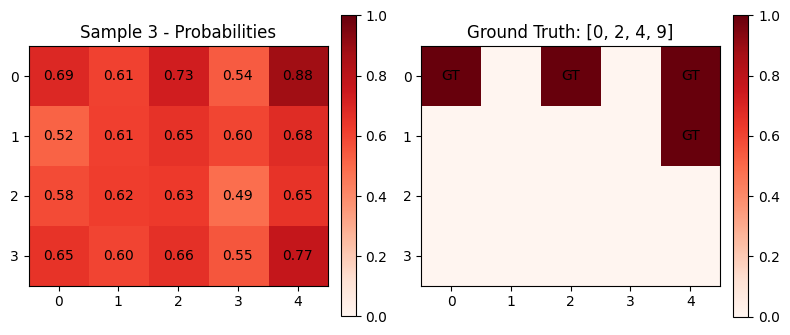

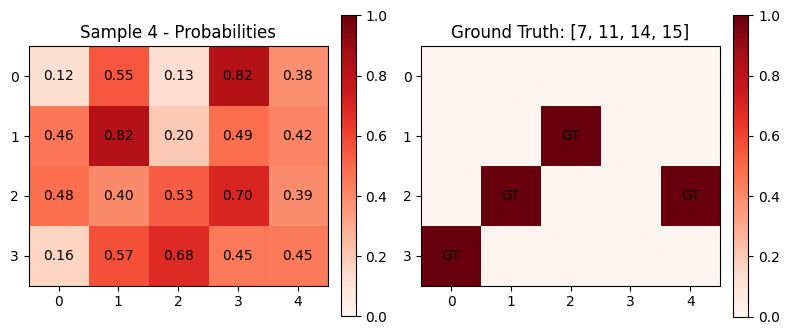

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_probs_with_gt(y_pred_proba, y_true, sample_indices=None, save_dir=None):
    """
    y_pred_proba: np.ndarray, shape (N, 20)，预测概率
    y_true: 
        - 若 shape (N,): 表示单标签 0~19
        - 若 shape (N,20): 表示多标签 / one-hot（比如有 4 个 1）
    """
    probs = np.asarray(y_pred_proba)
    y_true_arr = np.asarray(y_true)
    print(probs.shape, y_true_arr.shape)

    N = probs.shape[0]
    if sample_indices is None:
        sample_indices = range(min(10, N))

    for idx in sample_indices:
        p = probs[idx]  # (20,)

        # 概率 4×5
        prob_grid = p.reshape(4, 5)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # ========= 左：概率 =========
        im0 = axes[0].imshow(prob_grid, cmap='Reds', vmin=0, vmax=1)
        axes[0].set_title(f"Sample {idx} - Probabilities")
        axes[0].set_xticks(range(5))
        axes[0].set_yticks(range(4))

        for r in range(4):
            for c in range(5):
                axes[0].text(c, r, f"{prob_grid[r, c]:.2f}",
                             ha='center', va='center', color='black')

        fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

        # ========= 右：Ground Truth =========
        if y_true_arr.ndim == 1:
            # 单标签：0~19
            gt_idx = int(y_true_arr[idx])
            gt_vec = np.zeros(20, dtype=float)
            gt_vec[gt_idx] = 1.0
            gt_grid = gt_vec.reshape(4, 5)
            title = f"Ground Truth: class {gt_idx}"
        else:
            # 多标签 / one-hot：直接用这一行
            gt_vec = y_true_arr[idx]          # (20,)
            gt_grid = gt_vec.reshape(4, 5)
            pos_idx = np.where(gt_vec > 0.5)[0]
            title = f"Ground Truth: {list(pos_idx)}"  # 有哪些格子是 1

        im1 = axes[1].imshow(gt_grid, cmap='Reds', vmin=0, vmax=1)
        axes[1].set_title(title)
        axes[1].set_xticks(range(5))
        axes[1].set_yticks(range(4))

        # 把为 1 的格子标出来
        for k in np.where(gt_vec > 0.5)[0]:
            r, c = divmod(k, 5)
            axes[1].text(c, r, "GT",
                         ha='center', va='center', color='black', fontsize=10)

        fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        plt.tight_layout()

        if save_dir is not None:
            plt.savefig(f"{save_dir}/sample_{idx}.png", dpi=150)
            plt.close(fig)
        else:
            plt.show()
plot_probs_with_gt(all_probs.reshape(-1, 20), y_test.reshape(-1, 20), sample_indices=range(5))


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_hits_topk(df_with_prob, k):
    hits_list = []
    full_count = 0
    for (_, _), g in df_with_prob.groupby(['ID', 'round']):
        g_sorted = g.sort_values('prob', ascending=False)
        topk = g_sorted.head(k)
        hits = topk['label'].sum()
        hits_list.append(hits)
        if hits == 4:
            full_count += 1
    mean_hits = float(np.mean(hits_list))
    full_ratio = full_count / len(hits_list)
    return mean_hits, full_ratio


def summarize_model_performance(name, all_probs, all_labels, test_mask, data_img):
    auc = roc_auc_score(all_labels, all_probs)
    test_df_epoch = data_img.loc[test_mask].copy().reset_index(drop=True)
    assert len(test_df_epoch) == len(all_probs)
    test_df_epoch['prob'] = all_probs

    res = {'model': name, 'AUC': auc}

    for k in [4, 8, 12]:
        mean_hits, full_ratio = eval_hits_topk(test_df_epoch, k)
        res[f'hits@{k}'] = mean_hits
        res[f'cover@{k}'] = full_ratio

    return res


def run_experiment(exp_name, feature_cols_num, data_img, n_epochs=30, lr=1e-3, batch_size=256):
    X_train, y_train, train_loader, test_loader, test_mask, y_test = get_loaders(
        data_img, feature_cols_num=feature_cols_num
    )

    input_dim = X_train.shape[1]
    model = MLP(input_dim).to(device)

    pos = y_train.sum()
    neg = len(y_train) - pos
    pos_weight_value = neg / pos
    pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32, device=device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        # 你也可以在这里 print 一下 loss，但消融可以只看最终 epoch 的结果
        # print(f"[{exp_name}] Epoch {epoch:02d} | train loss {avg_loss:.4f}")

    # 最终在 test 上评估
    model.eval()
    all_probs_list = []
    all_labels_list = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs_list.append(probs.cpu())
            all_labels_list.append(yb)

    all_probs = torch.cat(all_probs_list).numpy()
    all_labels = torch.cat(all_labels_list).numpy()

    # 汇总指标
    res = summarize_model_performance(exp_name, all_probs, all_labels, test_mask, data_img)
    return res


In [ ]:
features_full = [
    "round",
    "img_id",
    "expltime",
    "cnt_before",
    "avg_pay_before",
    "early_reward",
]

features_no_expl = [
    "round",
    "img_id",
    "cnt_before",
    "avg_pay_before",
    "early_reward",
]

features_no_history = [
    "round",
    "img_id",
    "expltime",
    "early_reward",
]

features_no_early = [
    "round",
    "img_id",
    "expltime",
    "cnt_before",
    "avg_pay_before",
]


In [ ]:
results = []

results.append(run_experiment("Full",           features_full,       data_img))
results.append(run_experiment("No expltime",    features_no_expl,    data_img))
results.append(run_experiment("No history",     features_no_history, data_img))
results.append(run_experiment("No early_reward",features_no_early,   data_img))

ablation_df = pd.DataFrame(results)
print(ablation_df)


             model       AUC    hits@4   cover@4    hits@8   cover@8  \
0             Full  0.692028  1.586777  0.066116  2.537190  0.322314   
1      No expltime  0.670256  1.669421  0.148760  2.380165  0.314050   
2       No history  0.662562  1.586777  0.132231  2.314050  0.363636   
3  No early_reward  0.666960  1.677686  0.090909  2.404959  0.314050   

    hits@12  cover@12  
0  3.049587  0.528926  
1  3.082645  0.578512  
2  3.033058  0.578512  
3  3.074380  0.528926  


In [ ]:
y_test_all = data_img.loc[test_mask, 'label'].astype(int).values

np.random.seed(42)
rand_probs = np.random.rand(len(y_test_all))
rand_res = summarize_model_performance(
    name="Random",
    all_probs=rand_probs,
    all_labels=y_test_all,
    test_mask=test_mask,
    data_img=data_img,
)

ablation_df = pd.concat(
    [ablation_df, pd.DataFrame([rand_res])],
    ignore_index=True
)

print(ablation_df)

             model       AUC    hits@4   cover@4    hits@8   cover@8  \
0             Full  0.692028  1.586777  0.066116  2.537190  0.322314   
1      No expltime  0.670256  1.669421  0.148760  2.380165  0.314050   
2       No history  0.662562  1.586777  0.132231  2.314050  0.363636   
3  No early_reward  0.666960  1.677686  0.090909  2.404959  0.314050   
4           Random  0.514254  0.859504  0.000000  1.586777  0.008264   

    hits@12  cover@12  
0  3.049587  0.528926  
1  3.082645  0.578512  
2  3.033058  0.578512  
3  3.074380  0.528926  
4  2.404959  0.074380  
